In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
import seaborn as sn  
import re 
import tweepy 
from tweepy import OAuthHandler 
from textblob import TextBlob 
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import GridSearchCV

In [2]:
filename = 'Hashtags_fullExport_clean.csv'

## Data Loading

In [3]:
import pandas as pd
import random

df = pd.read_csv(filename,header=0)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,time,created_at,from_user_name,text,filter_level,possibly_sensitive,...,from_user_followercount,from_user_friendcount,from_user_favourites_count,from_user_listed,from_user_withheld_scope,from_user_created_at,mentions,hashtags,is_retweet,clean_text
0,0,0,0,1225328035961999361,1580975943,2020-02-06 07:59:03,bukimoon,RT @insight_co_kr: Handsome Jung Ga Ram 훈훈한 미...,none,NaN,...,986,237,350075,43,NaN,2013-12-14 22:55:03,insight_co_kr,정가람; 배우; 연기자; 영화; 시사회; junggaram; style; kacto...,True,: Handsome Jung Ga Ram 훈훈한 미소가 너무 잘생긴 배우 정가람
1,1,1,1,1225328235044581376,1580975991,2020-02-06 07:59:51,SoVogueSwiss,Unser Tipp: Ebel - Audemars Piguet - Breguet ...,none,0.0,...,1497,574,72,15,NaN,2016-04-05 13:47:14,NaN,sovogueswiss; watchporn; watchaddict; watchlov...,False,Unser Tipp: Ebel - Audemars Piguet - Breguet -
2,2,2,2,1225328272700870656,1580976000,2020-02-06 08:00:00,alejandro_dsign,Que el nuevo bob de Paula Echevarría no te dis...,none,0.0,...,23647,39378,453,130,NaN,2015-04-01 17:36:32,NaN,AlejandroBetancourt; Fashion; Trendy; Designer,False,Que el nuevo bob de Paula Echevarría no te dis...
3,3,3,3,1225328292036784128,1580976004,2020-02-06 08:00:04,ThreadLaced,Navy Kona Fruit Cardigan Price: $500 https://...,none,0.0,...,402,115,119,3,NaN,2016-12-20 14:33:32,NaN,Fashion; style; threadLace,False,Navy Kona Fruit Cardigan Price: $500
4,4,4,4,1225328306012217344,1580976008,2020-02-06 08:00:08,dinfomall,#fashion #indiedev #women #gamedev #amazon #on...,none,0.0,...,28414,1999,30629,89,NaN,2018-01-10 05:55:10,NaN,fashion; indiedev; women; gamedev; amazon; onl...,False,Almost Gone Deal!


In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'time',
       'created_at', 'from_user_name', 'text', 'filter_level',
       'possibly_sensitive', 'withheld_copyright', 'withheld_scope',
       'truncated', 'retweet_count', 'favorite_count', 'lang', 'to_user_name',
       'in_reply_to_status_id', 'quoted_status_id', 'source', 'location',
       'lat', 'lng', 'from_user_id', 'from_user_realname',
       'from_user_verified', 'from_user_description', 'from_user_url',
       'from_user_profile_image_url', 'from_user_utcoffset',
       'from_user_timezone', 'from_user_lang', 'from_user_tweetcount',
       'from_user_followercount', 'from_user_friendcount',
       'from_user_favourites_count', 'from_user_listed',
       'from_user_withheld_scope', 'from_user_created_at', 'mentions',
       'hashtags', 'is_retweet', 'clean_text'],
      dtype='object')

In [6]:
tweet = df[['clean_text','hashtags', 'mentions']]

In [7]:
tweet.head()

,clean_text,hashtags,mentions
0,: Handsome Jung Ga Ram 훈훈한 미소가 너무 잘생긴 배우 정가람,정가람; 배우; 연기자; 영화; 시사회; junggaram; style; kacto...,insight_co_kr
1,Unser Tipp: Ebel - Audemars Piguet - Breguet -,sovogueswiss; watchporn; watchaddict; watchlov...,NaN
2,Que el nuevo bob de Paula Echevarría no te dis...,AlejandroBetancourt; Fashion; Trendy; Designer,NaN
3,Navy Kona Fruit Cardigan Price: $500,Fashion; style; threadLace,NaN
4,Almost Gone Deal!,fashion; indiedev; women; gamedev; amazon; onl...,NaN


In [8]:
tweet.shape

(1123314, 3)

## Data Cleaning

In [9]:
tweet.clean_text = tweet.clean_text[tweet.clean_text.notnull()]
tweet.clean_text = tweet.clean_text.str.lower()
tweet.clean_text = tweet.clean_text.str.replace('[^\w\s]', '')
tweet.clean_text

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0                handsome jung ga ram 훈훈한 미소가 너무 잘생긴 배우 정가람 
1                unser tipp ebel  audemars piguet  breguet  
2          que el nuevo bob de paula echevarría no te dis...
3                        navy kona fruit cardigan price 500 
4                                          almost gone deal 
                                 ...                        
1123309                  nyc vlog  pa 1  star wars exhibit  
1123310     cookie cream cracker ou piraquê deixa um pra ...
1123311                                                     
1123312    some previews for april releases  stay tune on...
1123313     le message est bien passé merci  je suis 7jr7...
Name: clean_text, Length: 1123314, dtype: object

In [10]:
tweet.hashtags = tweet.hashtags[tweet.hashtags.notnull()]
tweet.hashtags = tweet.hashtags.str.lower()
tweet.hashtags = tweet.hashtags.str.replace('[^\w\s]', '')
tweet.hashtags

0          정가람 배우 연기자 영화 시사회 junggaram style kactor kmovi...
1          sovogueswiss watchporn watchaddict watchlover ...
2                alejandrobetancourt fashion trendy designer
3                                   fashion style threadlace
4          fashion indiedev women gamedev amazon online m...
                                 ...                        
1123309        beauty fashion music lifestyle styleastronaut
1123310      fluo costume ponytail style fashion keulla ootd
1123311             bakelite lariat necklace fashion jewelry
1123312    fashion clothes onlinestore holditdown clothin...
1123313    startuplife designer fashion artisteauteure fr...
Name: hashtags, Length: 1123314, dtype: object

In [11]:
tweet.mentions = tweet.mentions.str.lower()
tweet.mentions = tweet.mentions.str.replace('[^\w\s]', '')
tweet.mentions.dropna(inplace = True)
tweet.mentions

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4784: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


0                                              insight_co_kr
10                                             insoc_on_ebay
11                                       lorrtighe pausefest
12                                 queridasfashion havenlust
23         queridasfashion simofsevilla revblancosnegro h...
                                 ...                        
1123303                                      swinger_jewelry
1123304                                      swinger_jewelry
1123310                                       fernandakeulla
1123311                                      martinimermaids
1123313                                       gouvernementfr
Name: mentions, Length: 797169, dtype: object

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [13]:
tweets = tweet.clean_text.astype(str)
tweets = tweets.apply(lambda x: " ".join(word.lower() for word in x.split()))
tweets

0                 handsome jung ga ram 훈훈한 미소가 너무 잘생긴 배우 정가람
1                    unser tipp ebel audemars piguet breguet
2          que el nuevo bob de paula echevarría no te dis...
3                         navy kona fruit cardigan price 500
4                                           almost gone deal
                                 ...                        
1123309                      nyc vlog pa 1 star wars exhibit
1123310    cookie cream cracker ou piraquê deixa um pra b...
1123311                                                     
1123312    some previews for april releases stay tune on ...
1123313    le message est bien passé merci je suis 7jr7 e...
Name: clean_text, Length: 1123314, dtype: object

## Removing stopwords

In [14]:
#Generating stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [15]:
#Removing stopwords
tweets = pd.Series(tweets)
#removing digits and 1/2 character words
tweets_words = tweets.str.replace('\d+', '')
tweets_words = tweets_words.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
tweets_words = tweets_words.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
tweets_words

0                          handsome jung ram 훈훈한 미소가 잘생긴 정가람
1                    unser tipp ebel audemars piguet breguet
2          que nuevo bob paula echevarría distraiga tende...
3                             navy kona fruit cardigan price
4                                           almost gone deal
                                 ...                        
1123309                           nyc vlog star wars exhibit
1123310    cookie cream cracker piraquê deixa pra biscoit...
1123311                                                     
1123312    previews april releases stay tune order inquiries
1123313        message est bien passé merci suis télétravail
Name: clean_text, Length: 1123314, dtype: object

In [16]:
pd.Series(" ".join(tweets_words).split()).value_counts()[:20]

check       332906
good        326880
share       317849
items       317381
loving      315771
show         81189
fashion      46584
new          42912
follow       41122
chance       35748
win          35578
runway       35171
backpack     35163
look         26217
fall         26047
mini         20005
marc         18554
jacobs       18211
week         17864
dress        15850
dtype: int64

In [17]:
#Removing more stopwords based on top values from above
other_stop_words = ['womens','shop','share','mens','women','check','collection','us','price','set','one','top','free','shoes','get', 'wear', 'make', 'see', 'today', 'aist', 'member', 'new', 'look', 'watch', 'come', 'runway', 'fashion', 'fashion week', 'thanks', 'show', 'take', 'style', 'week', 'model', 'de', 'la', '2020', 'black', 'size', 'en', 'hair', 'show', 'en', 'day', 'check' 'collection', 'dress']
tweets_words = tweets_words.apply(lambda x: " ".join(word for word in x.split() if word not in other_stop_words))

In [18]:
pd.Series(" ".join(tweets_words).split()).value_counts()[:50]

good          326880
items         317381
loving        315771
follow         41122
chance         35748
win            35578
backpack       35163
fall           26047
mini           20005
marc           18554
jacobs         18211
joy            14483
best           13455
first          12922
love           12488
york           12423
กผลตโชค        12161
hadid          11775
live           11670
like           10915
appearance     10437
backstage      10432
made           10118
fans            9207
perfect         9167
chinese         9021
bag             8902
red             8765
getting         8733
bella           8627
february        8472
seen            8331
milan           8268
front           8193
wink            7926
pokémon         7924
pikachu         7920
inspired        7881
photo           7579
thank           7476
white           7376
star            7245
stops           7035
spreading       7034
blue            6998
cover           6887
latest          6874
picture      

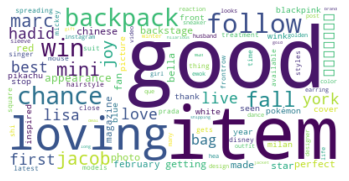

In [19]:
wordcloud = WordCloud(max_font_size=100, max_words=100,background_color="white", collocations=False).generate(' '.join(tweets_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Find most popular brands

In [117]:
brands = ['gucci','moncler','maxmara', 'prada', 'fendi', 'moschino','tods','versace', 'itscividini', 'itscividini', 'philipp plein', 'philippplein','boss', 'hugo boss' 'filaeurope', 'fila', 'armani', 'giorgioarmani', 'giorgio armani', 'alexandra.moura', 'miu miu', 'miumiu','tomford', 'ford', 'tom ford', 'rebeccaminkoff', 'minkoff', 'rebecca minkoff', 'toryburch', 'burch', 'tory burch', 'carolinaherrera', 'herrera', 'carolina herrera', 'marchesafashion', 'marchesa', 'kors', 'michaelkors', 'michael kors', 'marcjacobs', 'jacobs', 'marc jacobs', 'verawanggang', 'wang', 'vera', 'vera wang', 'oscardelarenta', 'oscar de la renta', 'delarenta', 'lang', 'helmut', 'helmutlang', 'helmut lang', 'coach','therow', 'the row', 'katespadeny', 'spade', 'kate spade', 'alice and olivia', 'alice+olivia','aliceandolivia','ragandbone', 'rag and bone', 'chanel','louisvuitton','balenciaga']
brands

['gucci',
 'moncler',
 'maxmara',
 'prada',
 'fendi',
 'moschino',
 'tods',
 'versace',
 'itscividini',
 'itscividini',
 'philipp plein',
 'philippplein',
 'boss',
 'hugo bossfilaeurope',
 'fila',
 'armani',
 'giorgioarmani',
 'giorgio armani',
 'alexandra.moura',
 'miu miu',
 'miumiu',
 'tomford',
 'ford',
 'tom ford',
 'rebeccaminkoff',
 'minkoff',
 'rebecca minkoff',
 'toryburch',
 'burch',
 'tory burch',
 'carolinaherrera',
 'herrera',
 'carolina herrera',
 'marchesafashion',
 'marchesa',
 'kors',
 'michaelkors',
 'michael kors',
 'marcjacobs',
 'jacobs',
 'marc jacobs',
 'verawanggang',
 'wang',
 'vera',
 'vera wang',
 'oscardelarenta',
 'oscar de la renta',
 'delarenta',
 'lang',
 'helmut',
 'helmutlang',
 'helmut lang',
 'coach',
 'therow',
 'the row',
 'katespadeny',
 'spade',
 'kate spade',
 'alice and olivia',
 'alice+olivia',
 'aliceandolivia',
 'ragandbone',
 'rag and bone',
 'chanel',
 'louisvuitton',
 'balenciaga']

In [21]:
brands_tweets = []
for row in tweets:
    for word in brands:
        if word in row:
            brands_tweets.append(row)
brands_tweets

['cameron dallas mentre sfila per the blonds x moulin rouge the musical durante la al al hirschfeld theathre new york desintoniopacheco ig 09092019',
 'cameron dallas mentre sfila per the blonds x moulin rouge the musical durante la al al hirschfeld theathre new york desintoniopacheco ig 09092019',
 'drake travis scott rosalía e virgil abloh no desfila da nike na bennett raglin',
 'gucci gucci coo cmon billieeilish this is an original from street walkin cheetah fer shur',
 'drake travis scott rosalía e virgil abloh no desfila da nike na bennett raglin',
 'drake travis scott rosalía e virgil abloh no desfila da nike na bennett raglin',
 'sir perky wine bottle stopper novelty banana plug beer beverage bottles preserver stopper hilarious gift evil home wine storage',
 'this mutiny r1 has been 3d printed using a pla filament that is over 40 recycled wood it looks like wood smells like wood shaves like a dream',
 'moncler polo shi price usd 255',
 'drake travis scott rosalía e virgil abloh 

In [22]:
#Removing stopwords
brands_tweets = pd.Series(brands_tweets)
brands_tweets
#removing digits and 1/2 character words
brands_tweets = brands_tweets.str.replace('\d+', '')
brands_tweets = brands_tweets.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
brands_tweets = brands_tweets.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
brands_tweets

0        cameron dallas mentre sfila per blonds moulin ...
1        cameron dallas mentre sfila per blonds moulin ...
2        drake travis scott rosalía virgil abloh desfil...
3        gucci gucci coo cmon billieeilish original str...
4        drake travis scott rosalía virgil abloh desfil...
                               ...                        
79279    shop lulus musthave trendy affordable prices s...
79280    michael kors damen analog quarz uhr mit edelst...
79281    michael kors damen analog quarz uhr mit edelst...
79282                                              miu miu
79283                                        versace bitch
Length: 79284, dtype: object

In [23]:
brands_tweets = brands_tweets.apply(lambda x: " ".join(word for word in x.split() if word in brands))


In [24]:
pd.Series(" ".join(brands_tweets).split()).value_counts()[:30]

jacobs             36918
prada               7262
kors                3558
coach               3198
versace             2620
fendi               2618
vera                2579
carolinaherrera     2568
gucci               2492
ford                2344
moschino            1964
moncler             1937
wang                1909
armani              1592
herrera              997
boss                 644
tods                 434
spade                211
burch                185
michaelkors          116
tomford               92
fila                  87
lang                  83
helmut                60
giorgioarmani         49
miumiu                19
minkoff               19
katespadeny           17
marchesa              14
marcjacobs            14
dtype: int64

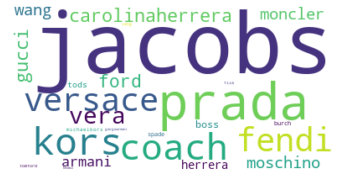

In [25]:
wordcloud_brands = WordCloud(max_font_size=100, max_words=50,background_color="white", collocations=False).generate(' '.join(brands_tweets))
plt.imshow(wordcloud_brands, interpolation='bilinear')
plt.axis("off")
plt.show()

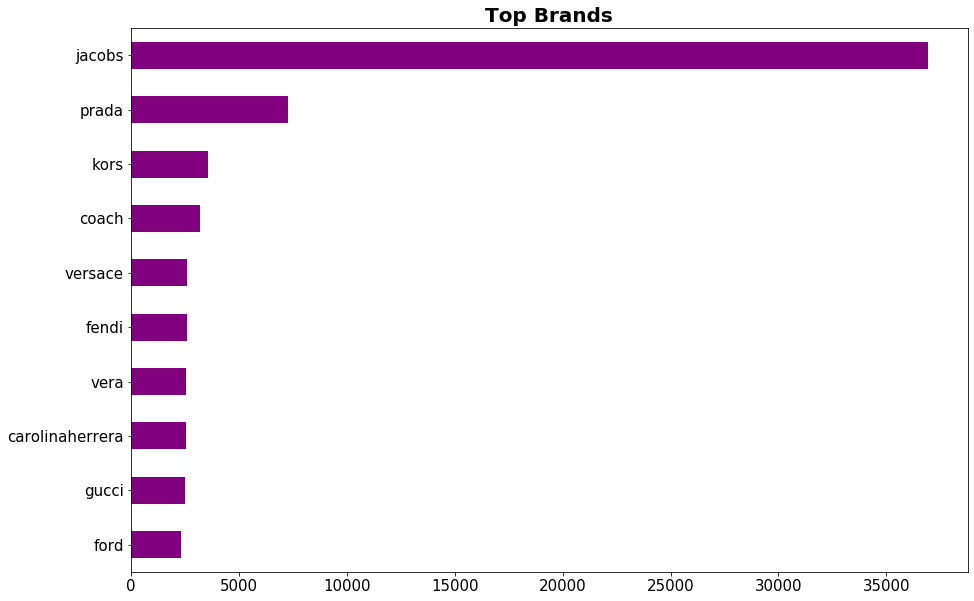

In [131]:
import matplotlib.pyplot as plot

top_brands = pd.Series(" ".join(brands_tweets).split()).value_counts()[:10]
top_brands = top_brands.sort_values()
fig = plt.figure(figsize = (15, 10)) 

top_brands.plot.barh(stacked = True, color = 'purple', fontsize=15)
plot.title('Top Brands', fontsize=20, fontweight='bold')

plt.savefig('top brands.png', transparent=True)
plot.show()


In [27]:
top_brands

herrera              997
armani              1592
wang                1909
moncler             1937
moschino            1964
ford                2344
gucci               2492
carolinaherrera     2568
vera                2579
fendi               2618
versace             2620
coach               3198
kors                3558
prada               7262
jacobs             36918
dtype: int64

## Top Brands: Marc Jacobs, Gucci, Kors, Coach, Prada


# Marc Jacobs Analysis

In [28]:
tweets

0                 handsome jung ga ram 훈훈한 미소가 너무 잘생긴 배우 정가람
1                    unser tipp ebel audemars piguet breguet
2          que el nuevo bob de paula echevarría no te dis...
3                         navy kona fruit cardigan price 500
4                                           almost gone deal
                                 ...                        
1123309                      nyc vlog pa 1 star wars exhibit
1123310    cookie cream cracker ou piraquê deixa um pra b...
1123311                                                     
1123312    some previews for april releases stay tune on ...
1123313    le message est bien passé merci je suis 7jr7 e...
Name: clean_text, Length: 1123314, dtype: object

In [29]:
mj = ['marc jacob', 'jacobs', 'jacob', 'marc jacobs', 'marcjacobs', 'marcjacob']
marcj = []
for row in tweets:
    for word in mj:
        if word in row:
            marcj.append(row)

marcj = pd.Series(marcj)
#removing digits and 1/2 character words
marcj = marcj.str.replace('\d+', '')
marcj = marcj.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
marcj = marcj.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
marcj 

0                         zendaya beau jacob elordi attend
1        jacobie jumpsuit last one size large grab sell...
2        gillian jacobs new fashion insider gillian jacobs
3        gillian jacobs new fashion insider gillian jacobs
4                            marc marcjacobs pandora price
                               ...                        
72902                     adore marc jacobs softshot purse
72903             miley cyrus hits runway marc jacobs show
72904             miley cyrus hits runway marc jacobs show
72905             miley cyrus hits runway marc jacobs show
72906             miley cyrus hits runway marc jacobs show
Length: 72907, dtype: object

In [30]:
pd.Series(" ".join(marcj).split()).value_counts()[:20]

marc         73006
jacobs       72798
show         38902
hadid        27512
bella        25350
models       21052
close        21016
watch        21016
reaction     21004
getting      21004
hilarious    21004
husband      21000
miley         9096
cyrus         8612
nicki         8006
minaj         6482
runway        5160
fashion       4498
stunning      4004
looked        4004
dtype: int64

In [31]:
mj_stop_words = ['york', 'marc','jacobs', 'hilarious','reaction','show','close','watch','getting','husband','hits','popped','new','fall']
mj = marcj.apply(lambda x: " ".join(word for word in x.split() if word not in mj_stop_words))
pd.Series(" ".join(mj).split()).value_counts()[:30]

hadid          27512
bella          25350
models         21052
miley           9096
cyrus           8612
nicki           8006
minaj           6482
runway          5160
fashion         4498
looked          4004
stunning        4004
gigi            2358
walking         2244
attending       1576
apa             1476
backstage       1462
desfile         1246
walked          1244
ending          1128
bang            1128
attends         1096
winter          1080
autumn          1028
attend          1021
sfilata          874
february         860
char             820
defrancesco      820
today            728
moda             714
dtype: int64

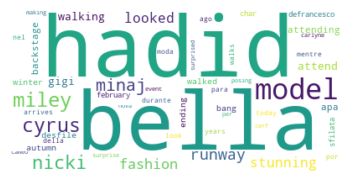

In [32]:
wordcloud2 = WordCloud(max_font_size=100, max_words=50,background_color="white", collocations=False).generate(' '.join(mj))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

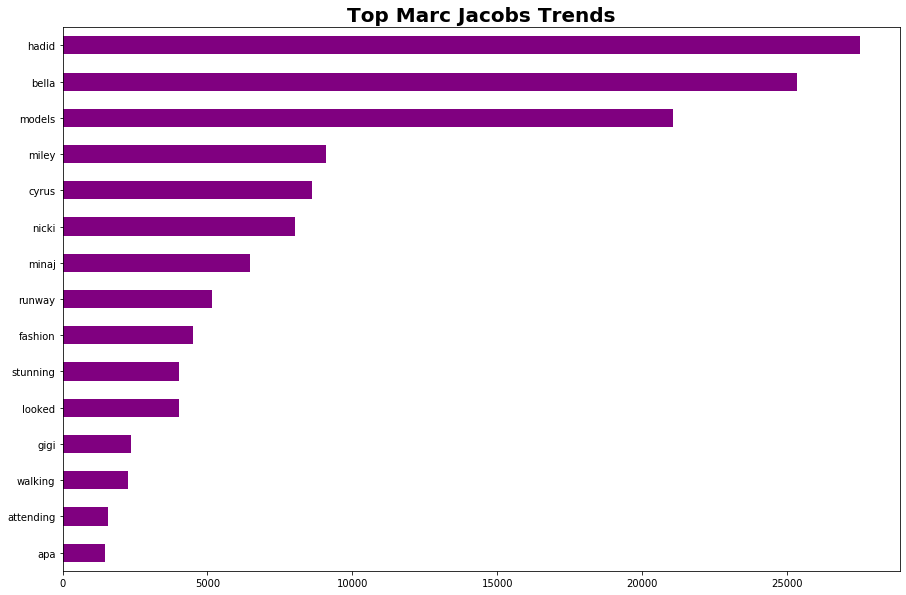

In [146]:
import matplotlib.pyplot as plot

top_mj = pd.Series(" ".join(mj).split()).value_counts()[:15]
top_mj = top_mj.sort_values()
fig = plt.figure(figsize = (15, 10)) 
top_mj.plot.barh(stacked = True, color = 'purple')

plot.title('Top Marc Jacobs Trends', fontsize=20, fontweight='bold')

plt.savefig('top mj.png', transparent=True)
plot.show()


## Marc Jacobs associated with Hadid, Cyrus, Nicki Minaj

# Hashtags Analysis

In [34]:
tweet.hashtags

0          정가람 배우 연기자 영화 시사회 junggaram style kactor kmovi...
1          sovogueswiss watchporn watchaddict watchlover ...
2                alejandrobetancourt fashion trendy designer
3                                   fashion style threadlace
4          fashion indiedev women gamedev amazon online m...
                                 ...                        
1123309        beauty fashion music lifestyle styleastronaut
1123310      fluo costume ponytail style fashion keulla ootd
1123311             bakelite lariat necklace fashion jewelry
1123312    fashion clothes onlinestore holditdown clothin...
1123313    startuplife designer fashion artisteauteure fr...
Name: hashtags, Length: 1123314, dtype: object

In [35]:
hasht = tweet.hashtags.str.replace(';', '')
hasht = hasht.astype(str)
hasht = hasht.str.lower()
hasht = hasht.str.replace('[^\w\s]', '')
hasht = hasht.replace(regex = [';'], value = '')

hasht

0          정가람 배우 연기자 영화 시사회 junggaram style kactor kmovi...
1          sovogueswiss watchporn watchaddict watchlover ...
2                alejandrobetancourt fashion trendy designer
3                                   fashion style threadlace
4          fashion indiedev women gamedev amazon online m...
                                 ...                        
1123309        beauty fashion music lifestyle styleastronaut
1123310      fluo costume ponytail style fashion keulla ootd
1123311             bakelite lariat necklace fashion jewelry
1123312    fashion clothes onlinestore holditdown clothin...
1123313    startuplife designer fashion artisteauteure fr...
Name: hashtags, Length: 1123314, dtype: object

In [36]:
hasht = hasht.str.replace('\d+', '')
hasht = hasht.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
hasht = hasht.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))


In [37]:
pd.Series(" ".join(hasht).split()).value_counts()[:20]

fashion             774640
style               501161
poshmark            317048
shopmycloset        316166
nyfw                146293
love                 66093
beauty               58200
mfw                  40863
giveaway             36489
loungefly            34624
blackpink            34533
lisa                 34236
art                  29904
milanfashionweek     29378
coachfw              29066
fashionblogger       28476
beautiful            27117
coachny              26098
lifestyle            25504
shopping             25345
dtype: int64

In [38]:
hasht_other_stopwords = ['check','share','items','show','new','follow','chance','win','look','fall','fashion','style']
hasht = hasht.apply(lambda x: " ".join(word for word in x.split() if word not in hasht_other_stopwords))

In [39]:
pd.Series(" ".join(hasht).split()).value_counts()[:20]

poshmark            317048
shopmycloset        316166
nyfw                146293
love                 66093
beauty               58200
mfw                  40863
giveaway             36489
loungefly            34624
blackpink            34533
lisa                 34236
art                  29904
milanfashionweek     29378
coachfw              29066
fashionblogger       28476
beautiful            27117
coachny              26098
lifestyle            25504
shopping             25345
fashionweek          25043
vogue                24343
dtype: int64

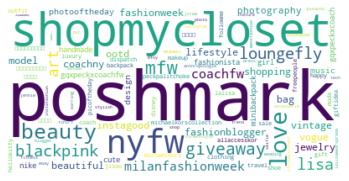

In [40]:
wordcloud4 = WordCloud(max_font_size=100, max_words=100,background_color="white", collocations = False).generate(' '.join(hasht))
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis("off")
plt.show()

In [41]:
top_hasht = pd.Series(" ".join(hasht).split()).value_counts()[:10]
top_hasht = top_hasht.sort_values()
top_hasht

lisa             34236
blackpink        34533
loungefly        34624
giveaway         36489
mfw              40863
beauty           58200
love             66093
nyfw            146293
shopmycloset    316166
poshmark        317048
dtype: int64

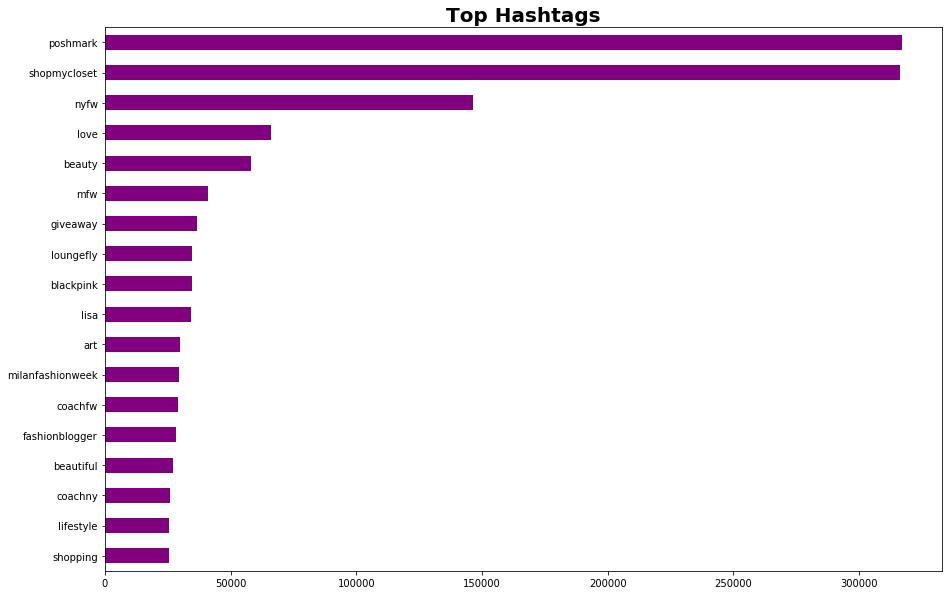

In [134]:
top_hasht = pd.Series(" ".join(hasht).split()).value_counts()[:18]
top_hasht = top_hasht.sort_values()
fig = plt.figure(figsize = (15, 10))
top_hasht.plot.barh(stacked = True, color = 'purple')

plot.title('Top Hashtags', fontsize=20, fontweight='bold')

plt.savefig('top hasht.png', transparent=True)

plot.show()

## Prada Analysis

In [43]:
hasht

0             정가람 연기자 시사회 junggaram kactor kmovie kpop kstar
1          sovogueswiss watchporn watchaddict watchlover ...
2                        alejandrobetancourt trendy designer
3                                                 threadlace
4                 indiedev women gamedev amazon online money
                                 ...                        
1123309                beauty music lifestyle styleastronaut
1123310                    fluo costume ponytail keulla ootd
1123311                     bakelite lariat necklace jewelry
1123312    clothes onlinestore holditdown clothing hiphop...
1123313        startuplife designer artisteauteure freelance
Name: hashtags, Length: 1123314, dtype: object

In [44]:
pp = ['prada']
prada = []
for row in hasht:
    for word in pp:
        if word in row:
            prada.append(row)

prada = pd.Series(prada)
#removing digits and 1/2 character words
prada = prada.str.replace('\d+', '')
prada = prada.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
# prada = prada.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
prada

0            poshmark shopmycloset julesleopold prada nike
1        poshmark shopmycloset prada salvatoreferragamo...
2            poshmark shopmycloset forever katespade prada
3                           agatharuizdelaprada madrid mfw
4                           agatharuizdelaprada madrid mfw
                               ...                        
13425    poshmark shopmycloset sbglam jackbybbdakota prada
13426    poshmark shopmycloset philliplim yohjiyamamoto...
13427             poshmark shopmycloset louisvuitton prada
13428              poshmark shopmycloset ankara prada next
13429                      miucciaprada makeupbypatmcgrath
Length: 13430, dtype: object

In [45]:
pd.Series(" ".join(prada).split()).value_counts()[:20]

lisa                10028
lalisawearsprada     8556
blackpink            8266
mfw                  6744
fashionweek          4955
lalisaxpradafw       4869
prada                4113
lalisa               3614
lalisaxprada         3561
pradafw              3459
milanfashionweek     3402
블랙핑크                 2372
밀라노                  2288
poshmark             1323
shopmycloset         1318
miucciaprada         1065
lisaxprada           1014
twitter               958
lisawearsprada        820
benvenutalalisa       698
dtype: int64

In [46]:
prada_stop_words = ['prada', 'pradafw20','twitter', 'mfw','first','milan','public','made','year','golden',]
prada = prada.apply(lambda x: " ".join(word for word in x.split() if word not in prada_stop_words))
pd.Series(" ".join(prada).split()).value_counts()[:10]

lisa                10028
lalisawearsprada     8556
blackpink            8266
fashionweek          4955
lalisaxpradafw       4869
lalisa               3614
lalisaxprada         3561
pradafw              3459
milanfashionweek     3402
블랙핑크                 2372
dtype: int64

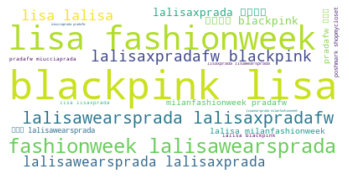

In [47]:
wordcloud5 = WordCloud(max_font_size=100, max_words=20,background_color="white",contour_color='black').generate(' '.join(prada))
plt.imshow(wordcloud5, interpolation='bilinear')
plt.axis("off")
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46972 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 45432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48660 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47001 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 54609 missing from c

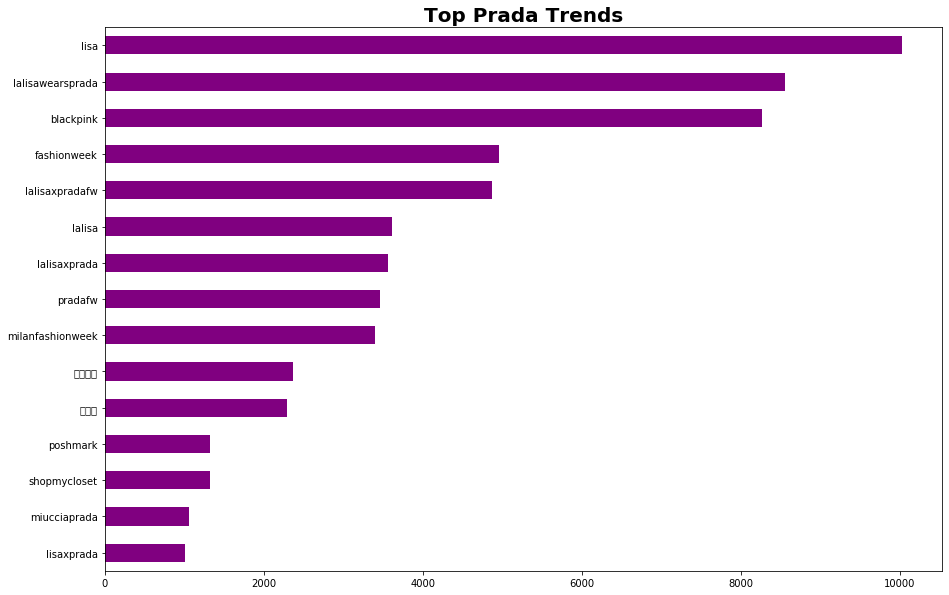

In [153]:
import matplotlib.pyplot as plot

top_prada = pd.Series(" ".join(prada).split()).value_counts()[:15]
top_prada = top_prada.sort_values()
fig = plt.figure(figsize = (15, 10)) 

top_prada.plot.barh(stacked = True, color = 'purple', fontsize=10)
plot.title('Top Prada Trends', fontsize=20, fontweight='bold')

plt.savefig('top prada.png', transparent=True)
plot.show()


## Coach Analysis

In [49]:
cofw = ['coach', 'coachfw20','coachny','gqxpeckxcoachfw20','gqxpeckxcoach']

In [67]:
coach = []
for row in hasht:
    for word in cofw:
        if word in row:
            coach.append(row)

coach = pd.Series(coach)
#removing digits and 1/2 character words
coach = coach.str.replace('\d+', '')
coach = coach.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
coach = coach.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
coach 

0               poshmark shopmycloset adidas kaisely coach
1        poshmark shopmycloset williamssonoma coach rozali
2               poshmark shopmycloset charlotterusse coach
3                  poshmark shopmycloset coach michaelkors
4            poshmark shopmycloset prettylittlething coach
                               ...                        
87858                    poshmark shopmycloset gucci coach
87859                poshmark shopmycloset coach katespade
87860     poshmark shopmycloset madewell michaelkors coach
87861         poshmark shopmycloset samedelman coach jcrew
87862    poshmark shopmycloset americaneagleoutfitters ...
Length: 87863, dtype: object

In [68]:
coach = pd.Series(coach)
pd.Series(" ".join(coach).split()).value_counts()[:30]

nyfw                 76326
coachfw              72327
coachny              70421
gqxpeckxcoach        55047
gqxpeckxcoachfw      54121
peckpalitchoke       44495
เปกผลตโชค            29603
coach                14698
poshmark             11227
shopmycloset         11213
jisoo                 5859
rosé                  5845
kikomizuhara          5834
thebangkokinsight     2886
gqthailand            2612
galaxya               1768
nyc                   1385
megantheestallion      700
michaelbjordan         610
michaelkors            591
yunazarai              482
fashionweek            477
kimseolhyun            468
nike                   381
katespade              376
kōki                   332
freepeople             301
quincy                 286
salemmitchell          274
gqxcoachxpeckfw        258
dtype: int64

In [69]:
coach_stop_words = ['coachfw20', 'coachny','coach', 'nyfw']
coach = coach.apply(lambda x: " ".join(word for word in x.split() if word not in coach_stop_words))
pd.Series(" ".join(coach).split()).value_counts()[:20]

coachfw              72327
gqxpeckxcoach        55047
gqxpeckxcoachfw      54121
peckpalitchoke       44495
เปกผลตโชค            29603
poshmark             11227
shopmycloset         11213
jisoo                 5859
rosé                  5845
kikomizuhara          5834
thebangkokinsight     2886
gqthailand            2612
galaxya               1768
nyc                   1385
megantheestallion      700
michaelbjordan         610
michaelkors            591
yunazarai              482
fashionweek            477
kimseolhyun            468
dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3648 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3611 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3621 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3605 missing from current

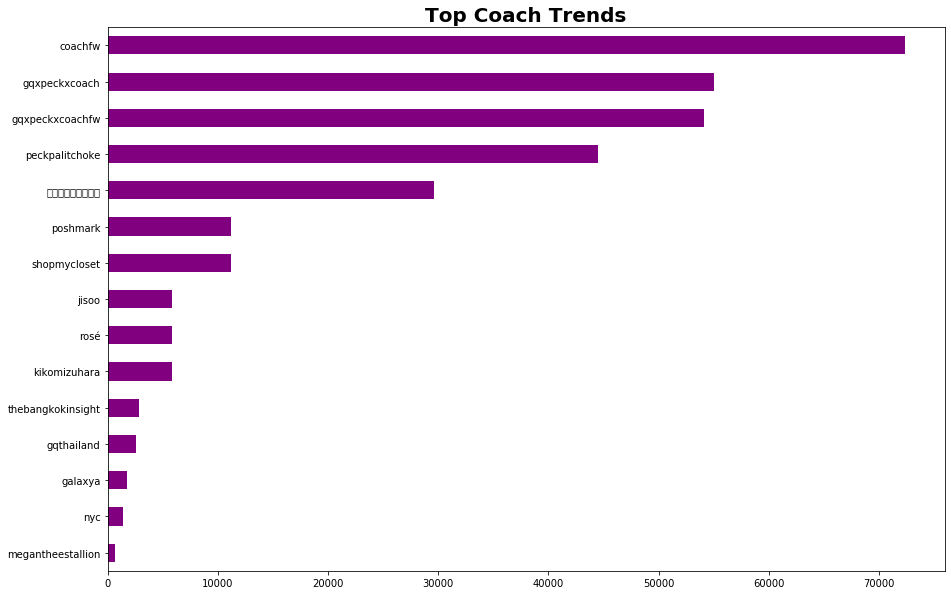

In [152]:
top_coach = pd.Series(" ".join(coach).split()).value_counts()[:15]
top_coach = top_coach.sort_values()
fig = plt.figure(figsize = (15, 10)) 

top_coach.plot.barh(stacked = True, color = 'purple', fontsize=10)
plot.title('Top Coach Trends', fontsize=20, fontweight='bold')

plt.savefig('top coach.png', transparent=True)

plot.show()

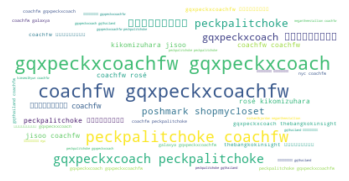

In [72]:
wordcloud6 = WordCloud(max_font_size=500, max_words=40,background_color="white").generate(' '.join(coach))
plt.imshow(wordcloud6, interpolation='bilinear')
plt.axis("off")
plt.show()

## Mentions Analysis

In [76]:
mentions = tweet.mentions.astype(str)
mentions.dropna(inplace=True)
mentions = mentions.str.lower()
mentions = mentions.str.replace('[^\w\s]', '')
mentions = mentions.replace(regex = [';'], value = '')
mentions

0                                              insight_co_kr
10                                             insoc_on_ebay
11                                       lorrtighe pausefest
12                                 queridasfashion havenlust
23         queridasfashion simofsevilla revblancosnegro h...
                                 ...                        
1123303                                      swinger_jewelry
1123304                                      swinger_jewelry
1123310                                       fernandakeulla
1123311                                      martinimermaids
1123313                                       gouvernementfr
Name: mentions, Length: 797169, dtype: object

In [78]:
mentions = mentions.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
pd.Series(" ".join(mentions).split()).value_counts()[:20]

poshmarkapp        315661
originalfunko       68817
loungefly           34437
ygofficialblink     28294
coach               23352
prada               15219
michaelkors         14656
dispatchsns         12568
globaltimesnews     12511
ebay                 8572
meenavoguee          8461
nickiminaj           8148
mefeater             7572
rvsmtown             7418
britishvogue         7324
popcrave             6791
hypebae              6761
hellokitty           5519
nyfw                 5463
etsy                 5366
dtype: int64

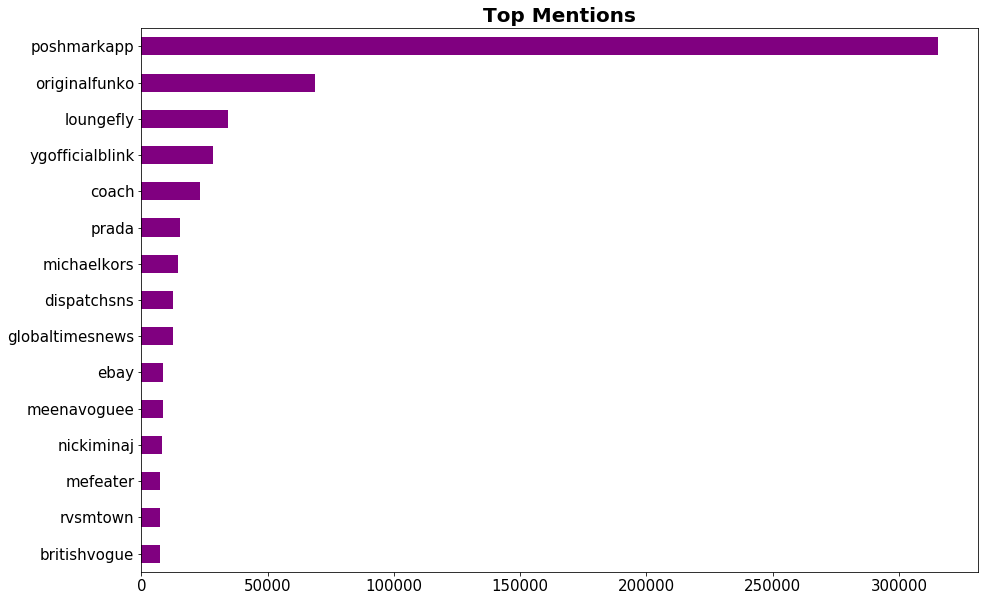

In [137]:
top_mentions = pd.Series(" ".join(mentions).split()).value_counts()[:15]
top_mentions = top_mentions.sort_values()
fig = plt.figure(figsize = (15, 10)) 

top_mentions.plot.barh(stacked = True, color = 'purple', fontsize=15)
plot.title('Top Mentions', fontsize=20, fontweight='bold')

plt.savefig('top mentions.png', transparent=True)

plot.show()

## Michael Kors Analysis

In [89]:
MK = ['michael', 'kors','michaelkors', 'michaelkorscollection', 'allaccesskors']
kors = []
for row in hasht:
    for word in MK:
        if word in row:
            kors.append(row)

kors = pd.Series(kors)
#removing digits and 1/2 character words
kors = kors.str.replace('\d+', '')
kors = kors.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
kors = kors.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
kors 

0         poshmark shopmycloset michaelkors underarmour ...
1         poshmark shopmycloset michaelkors underarmour ...
2         poshmark shopmycloset michaelkors underarmour ...
3                  poshmark shopmycloset hermes michaelkors
4                  poshmark shopmycloset hermes michaelkors
                                ...                        
112514    poshmark shopmycloset michaelmichaelkors bcbgm...
112515    poshmark shopmycloset timberland michaelrome v...
112516     poshmark shopmycloset madewell michaelkors coach
112517     poshmark shopmycloset madewell michaelkors coach
112518     poshmark shopmycloset madewell michaelkors coach
Length: 112519, dtype: object

In [90]:
kors = pd.Series(kors)
pd.Series(" ".join(kors).split()).value_counts()[:30]

nyfw                       75398
allaccesskors              70431
michaelkorscollection      69386
poshmark                   38939
shopmycloset               38905
_imyour_joy                36447
michaelkors                32686
michaelmichaelkors          9364
joyxmichaelkors             2697
coach                       2237
joy                         2021
redvelvet                   1918
레드벨벳                        1841
nike                        1357
katespade                   1294
freepeople                  1083
anthropologie                840
jcrew                        805
victoriassecret              672
forever                      614
vintage                      578
adidas                       543
zara                         527
oldnavy                      517
americaneagleoutfitters      504
loft                         495
toryburch                    484
bananarepublic               471
express                      427
pinkvictoriassecret          426
dtype: int

In [121]:
kors_stop_words = ['nyfw','poshmark','shopmycloset', 'michael', 'kors','michaelkors', 'michaelkorscollection', 'allaccesskors' ]
kors = kors.apply(lambda x: " ".join(word for word in x.split() if word not in kors_stop_words))
kors = kors.apply(lambda x: " ".join(word for word in x.split() if word not in brands))
pd.Series(" ".join(kors).split()).value_counts()[:10]

_imyour_joy           36447
michaelmichaelkors     9364
joyxmichaelkors        2697
joy                    2021
redvelvet              1918
레드벨벳                   1841
nike                   1357
katespade              1294
freepeople             1083
anthropologie           840
dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48296 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48307 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 47112 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 46300 missing from cur

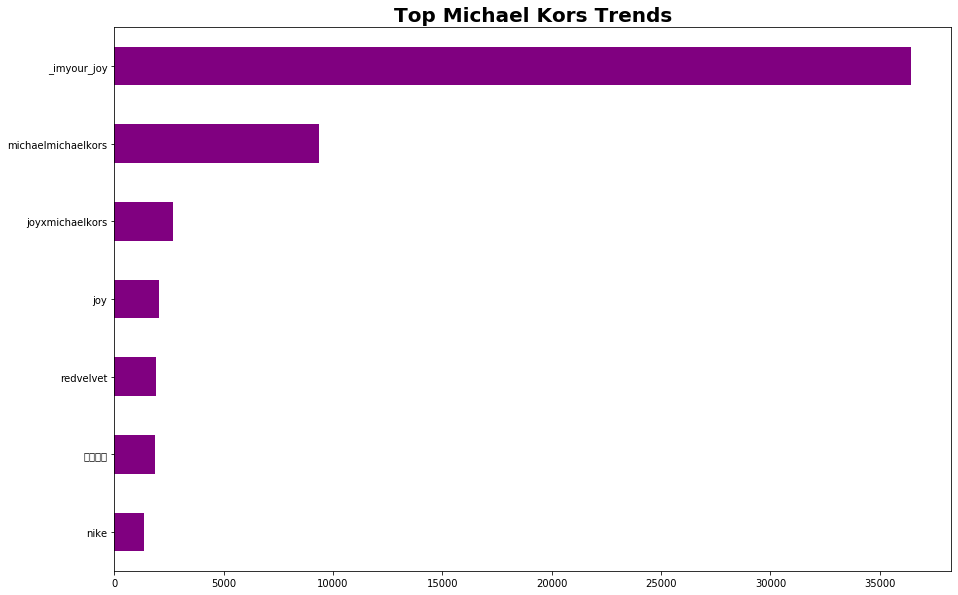

In [151]:
top_kors = pd.Series(" ".join(kors).split()).value_counts()[:7]
top_kors = top_kors.sort_values()
fig = plt.figure(figsize = (15, 10)) 

top_kors.plot.barh(stacked = True, color = 'purple', fontsize=10)
plot.title('Top Michael Kors Trends', fontsize=20, fontweight='bold')

plt.savefig('top mk.png', transparent=True)

plot.show()

## Gucci Analysis


In [109]:
gg = ['gucci']
gucci = []
for row in hasht:
    for word in gg:
        if word in row:
            gucci.append(row)

gucci = pd.Series(gucci)
#removing digits and 1/2 character words
gucci = gucci.str.replace('\d+', '')
gucci = gucci.apply(lambda x:" ".join([char for char in x.split() if len(char)>2]))
gucci = gucci.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))
gucci 

0               poshmark shopmycloset danskin lulus gucci
1       poshmark shopmycloset gucci stuartweitzman mar...
2       gucci vintage billieeilish catwalk model fairf...
3                        poshmark shopmycloset gucci nike
4        poshmark shopmycloset fashionnova burberry gucci
                              ...                        
7096                          poshmark shopmycloset gucci
7097                     fashionblogger gucci vincecamuto
7098      poshmark shopmycloset gucci louisvuitton escada
7099    poshmark shopmycloset calvinklein rosihechoenm...
7100                    poshmark shopmycloset gucci coach
Length: 7101, dtype: object

In [142]:
gucci_stop_words = ['gucci','milanfashionweek','mfw', 'guccifw20','poshmark','shopmycloset','아이유','이지은']
gucci = gucci.apply(lambda x: " ".join(word for word in x.split() if word not in gucci_stop_words))
gucci = gucci.apply(lambda x: " ".join(word for word in x.split() if word not in brands))

pd.Series(" ".join(gucci).split()).value_counts()[:10]

iuxgucci    1251
guccifw      854
vintage      768
designer     720
jewelry      676
leejieun     609
shoes        579
crochet      573
handbags     569
hermes       566
dtype: int64

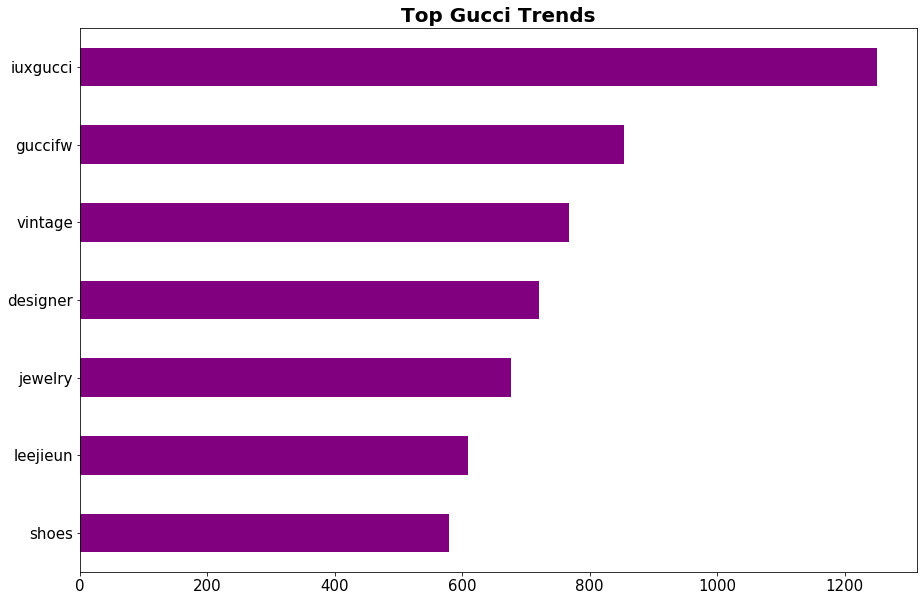

In [144]:
top_gucci = pd.Series(" ".join(gucci).split()).value_counts()[:7]
top_gucci = top_gucci.sort_values()
fig = plt.figure(figsize = (15, 10)) 

top_gucci.plot.barh(stacked = True, color = 'purple', fontsize=15)
plot.title('Top Gucci Trends', fontsize=20, fontweight='bold')

plt.savefig('top gucci.png', transparent=True)

plot.show()